In [11]:
# 1. 데이터 전처리 관련 모듈 import
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

# 2. 데이터 분할
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, cross_val_predict, cross_validate, StratifiedKFold

# 3. 사용할 알고리즘 import
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.inspection import PartialDependenceDisplay

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 4. 성능 평가
from sklearn.metrics import r2_score, root_mean_squared_error, root_mean_squared_log_error, mean_absolute_percentage_error

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pickle
import shap
import datetime as dt
import joblib

def getScore(name, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    # rmsle = root_mean_squared_log_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'{name}, r2: {r2:.3f}, mape: {mape:.3f}, rmse: {rmse:.3f}')

In [131]:
# import df - 33차(최종) 모델에 사용된 df에서 multicollinearity 높은 변수 제거함 (38차 df)
df = pd.read_csv('./df_38thtrial.csv', index_col = 'Datetime')

LR Cross-Validation Scores: [0.61906161 0.36063228 0.37969513 0.42280725 0.39689839 0.35849192
 0.54362098 0.61975866 0.35724741 0.53349726]
LR CV Average Score: 0.4591710894156421
lr_validation, r2: 0.366, mape: 0.281, rmse: 0.015
lr_test, r2: 0.484, mape: 0.270, rmse: 0.013


<Axes: xlabel='features'>

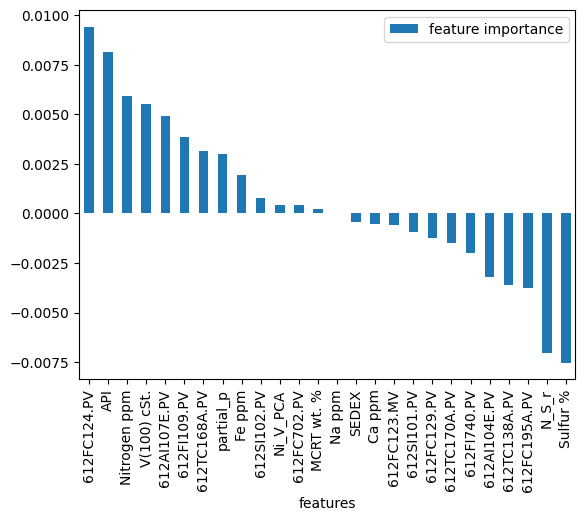

In [82]:
# modeling
x = df.drop('SHFT_avg', axis=1)
y = df['SHFT_avg']

# # standard scaling - 최초 1회 수행
# scaler = StandardScaler()
# scaler.fit(x)  # Only fit on the training data
# x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
# # scaler 함수 pkl로 추출
# joblib.dump(scaler, 'scaler.pkl')

# # pca - 최초 1회 수행
# pca = PCA(n_components=1)  # Keep one principal component
# pca.fit(x_scaled[['Ni ppm', 'V ppm']])
# x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
# x_scaled['Ni_V_PCA'] = x_pca
# x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# # pca 함수 pkl로 추출
# joblib.dump(pca, 'pca.pkl')

# scaler, pca는 동일한 모델 사용
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# train/validation/test split
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.4, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)
# print(x_train.shape, x_val.shape, x_test.shape)
# print(y_train.shape, y_val.shape, y_test.shape)
x_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

# model = linear regression
lr = LinearRegression()

# 1. cross validation을 통해 모델 성능 1차 확인
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores_lr = cross_val_score(lr, x_train, y_train, cv=kfold, scoring='r2', error_score='raise')
print("LR Cross-Validation Scores:", scores_lr)
print("LR CV Average Score:", scores_lr.mean())

# 2. cross validation 결과 만족
# -> cross validation 및 hyper parameter tuning(미수행)을 통해 얻은 모델을 바탕으로 validation set에 대한 성능 확인
lr.fit(x_train, y_train)
y_val_pred_lr = lr.predict(x_val)
getScore('lr_validation', y_val, y_val_pred_lr)

# 3. validation set에 대한 성능 확인 결과 만족
# -> train+validation set으로 모델 학습한 뒤 test set에 대한 성능 최종 확인
lr.fit(x_train_val, y_train_val)
y_test_pred_lr = lr.predict(x_test)
getScore('lr_test', y_test, y_test_pred_lr)
# lr 함수 pkl로 추출
joblib.dump(lr, 'lr.pkl')

lr_importance = lr.coef_
fi_df_lr = pd.DataFrame({'features':x_scaled.columns, 'feature importance':lr_importance})
fi_df_lr.sort_values(by='feature importance',ascending=False).plot(kind='bar', x='features')

In [101]:
# assay -> df 변환 함수
def convert_df(df_input):
    # crude information 담고 있는 df 따로 추출
    df_info = df_input.iloc[:,:6]
    df_info.columns = df_info.iloc[0]
    df_info = df_info[1:].reset_index(drop=True)
    
    # VR Feed 관련 열: [118:152]
    df_input_vr_feed = df_input.iloc[:, 118:152]
    
    # 의미없는 맨 첫 열 제거하고 두번째 열을 column 이름으로 사용
    df_input_vr_feed.columns = df_input_vr_feed.iloc[0]
    df_input_vr_feed = df_input_vr_feed[1:].reset_index(drop=True)
    
    # 제거할 열: 0, 2, 5, 7,11, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33
    col_to_drop = df_input_vr_feed.columns[[0, 2, 5, 7,11, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]]
    df_input_vr_feed.drop(col_to_drop, axis=1, inplace=True)
    
    # df dtype 변경
    for col in df_input_vr_feed.columns:
        df_input_vr_feed[col] = df_input_vr_feed[col].astype('float64')
    
    # 결측치는 평균으로 채우기
    for col in df_input_vr_feed.columns:
        df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)
    
    # 계산으로 만들어지는 열 추가
    df_input_vr_feed['N_S_r'] = df_input_vr_feed['Nitrogen ppm']/df_input_vr_feed['Sulfur %']
    
    # 위 df에 2024년 평균 운전 데이터를 merge
    # 먼저 2024년 평균 운전 데이터를 df로 구성
    df = pd.read_csv('df_38thtrial.csv')
    df['Datetime'] = df['Datetime'].astype('datetime64[ns]')
    df.set_index('Datetime', drop=True, inplace=True)
    df = df.loc[df.index.year == 2024]
    opavg2024_list = []
    for col in df.columns[:15]:
        opavg2024_list.append(df[col].mean())
    opavg2024_df = pd.merge(pd.DataFrame(df.columns[:15]), pd.DataFrame(opavg2024_list), left_index=True, right_index=True)
    opavg2024_df.columns = ['variable', 'avg']
    opavg2024_df_t = opavg2024_df.transpose()
    opavg2024_df_t.columns = opavg2024_df_t.iloc[0]
    opavg2024_df_t = opavg2024_df_t[1:].reset_index(drop=True)
    opavg2024_df_t_repeated = pd.DataFrame([opavg2024_df_t.iloc[0]] * len(df_input_vr_feed), columns=opavg2024_df_t.columns)
    opavg2024_df_t_repeated.reset_index(drop=True, inplace=True)
    
    df = pd.concat([opavg2024_df_t_repeated, df_input_vr_feed], axis=1)
    return df

C:\Users\C17402\AppData\Local\Temp\ipykernel_16416\3996342291.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)


<Axes: >

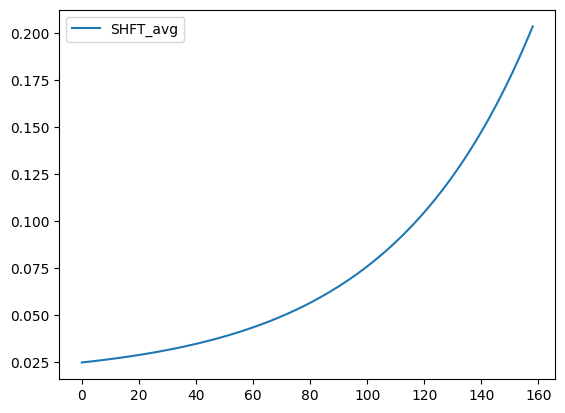

In [138]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - vis
# load original assay
df_assay = pd.read_csv('./Assay Summary_visco.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_feedonly = df_assay.loc[:,'API':]
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay, left_index=True, right_index=True)

df_assay_SHFT.plot()

C:\Users\C17402\AppData\Local\Temp\ipykernel_16416\3996342291.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)


<Axes: >

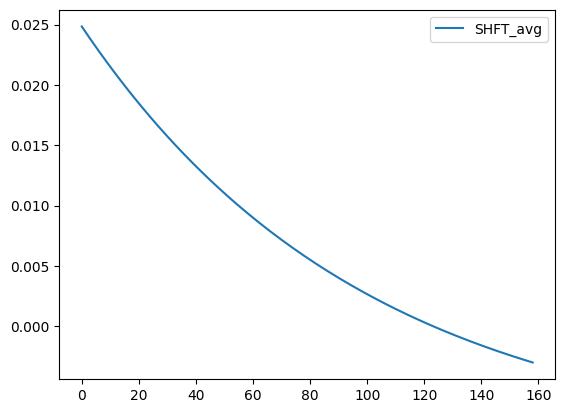

In [139]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - api
# load original assay
df_assay = pd.read_csv('./Assay Summary_api.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_feedonly = df_assay.loc[:,'API':]
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay, left_index=True, right_index=True)

df_assay_SHFT.plot()

C:\Users\C17402\AppData\Local\Temp\ipykernel_16416\3996342291.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)


<Axes: >

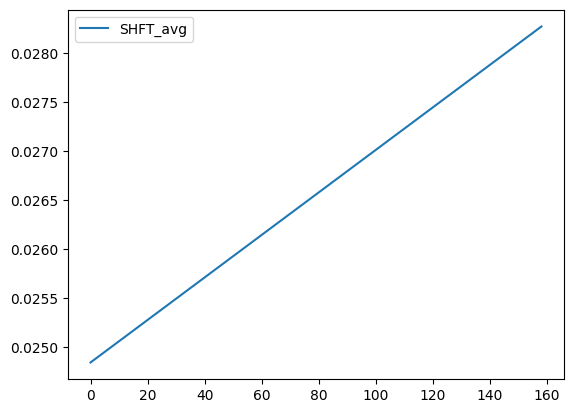

In [140]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - mcrt
# load original assay
df_assay = pd.read_csv('./Assay Summary_mcrt.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_feedonly = df_assay.loc[:,'API':]
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay, left_index=True, right_index=True)

df_assay_SHFT.plot()

C:\Users\C17402\AppData\Local\Temp\ipykernel_16416\3996342291.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)


<Axes: >

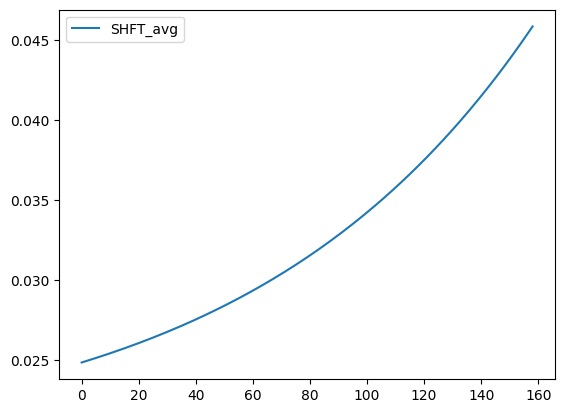

In [141]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - NiV
# load original assay
df_assay = pd.read_csv('./Assay Summary_NiV.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_feedonly = df_assay.loc[:,'API':]
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay, left_index=True, right_index=True)

df_assay_SHFT.plot()

C:\Users\C17402\AppData\Local\Temp\ipykernel_16416\3996342291.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)


<Axes: >

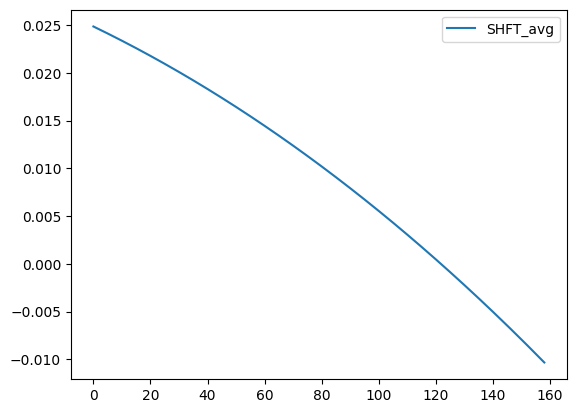

In [143]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - sulfur
# load original assay
df_assay = pd.read_csv('./Assay Summary_sulfur.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)
# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)
# prediction
lr = joblib.load('lr.pkl')
df_assay_feedonly = df_assay.loc[:,'API':]
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay, left_index=True, right_index=True)

df_assay_SHFT.plot()